In [61]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import time
import statistics
from tqdm import tqdm
import random

In [62]:
xg_df = pd.DataFrame(pd.read_pickle('dataset/intersection/statsbomb_matches_shots/shots_per_match.pkl')['shot_xgs'].sum())

In [63]:
# DP method
def assess_dp(p_is, repeat=30000):
    execution_times = []
    results = []
    for _ in range(repeat):
        execution_time = time.perf_counter_ns()
        # Initialize the dp table
        n = len(p_is)
        p_k = [1] + [0]*n
        # Iterate over the dp table
        for i in range(n+1):
            for c in range(i, 0, -1):
                inc = p_is[i-1]*p_k[c-1]
                p_k[c-1] -= inc
                p_k[c] += inc
        res = p_k
        execution_time = time.perf_counter_ns() - execution_time
        execution_times.append(execution_time)
        results.append(list(res))
    assert all([res == results[0] for res in results]), 'Results are not consistent'
    return res, statistics.mean(execution_times)

# FFT method
from poibin.poibin import PoiBin

def assess_fft(p_is, repeat=30000):
    execution_times = []
    results = []
    for _ in range(repeat):
        execution_time = time.perf_counter_ns()
        res = PoiBin(p_is).get_pmf_xi()
        execution_time = time.perf_counter_ns() - execution_time
        execution_times.append(execution_time)
        results.append(list(res))
    assert all([res == results[0] for res in results]), 'Results are not consistent'
    return res, statistics.mean(execution_times)

In [64]:
# DP method
def assess_one_dp(p_is):
    execution_time = time.perf_counter_ns()
    # Initialize the dp table
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    res = p_k
    execution_time = time.perf_counter_ns() - execution_time
    return res, execution_time

# FFT method
from poibin.poibin import PoiBin

def assess_one_fft(p_is):
    execution_time = time.perf_counter_ns()
    res = PoiBin(p_is).get_pmf_xi()
    execution_time = time.perf_counter_ns() - execution_time
    return res, execution_time

def simulation(p_is, n=2500):
    execution_time = time.perf_counter_ns()
    amnts = [0]*(len(p_is)+1)
    for _ in range(n):
        goal_amnt = sum([int(random.random() < p_i) for p_i in p_is])
        amnts[goal_amnt] += 1
    res = [amnt/n for amnt in amnts]
    execution_time = time.perf_counter_ns() - execution_time
    return res, execution_time

In [65]:
N = 50
RERUNS = 50
dp_times, fft_times, sim_times = {i: [] for i in range(1, N+1)}, {i: [] for i in range(1, N+1)}, {i: [] for i in range(1, N+1)}
total_runs = RERUNS*N
loopcount = 0

while any([len(dp_times[i]) < RERUNS for i in range(1, N+1)]) or any([len(fft_times[i]) < RERUNS for i in range(1, N+1)]):
    length = random.randint(1, N)
    if len(dp_times[length]) == RERUNS:
        continue
    p_is = xg_df.sample(length, replace=True).values.flatten().tolist()
    dp_times[length].append(assess_one_dp(p_is)[1])
    fft_times[length].append(assess_one_fft(p_is)[1])
    sim_times[length].append(simulation(p_is)[1])
    if loopcount % (total_runs//10) == 0:
        print(f'{loopcount}/{total_runs} runs completed')
    loopcount += 1

dp_times = [statistics.mean(dp_times[i]) for i in range(1, N+1)]
fft_times = [statistics.mean(fft_times[i]) for i in range(1, N+1)]
sim_times = [statistics.mean(sim_times[i]) for i in range(1, N+1)]

0/2500 runs completed
250/2500 runs completed
500/2500 runs completed
750/2500 runs completed
1000/2500 runs completed
1250/2500 runs completed
1500/2500 runs completed
1750/2500 runs completed
2000/2500 runs completed
2250/2500 runs completed


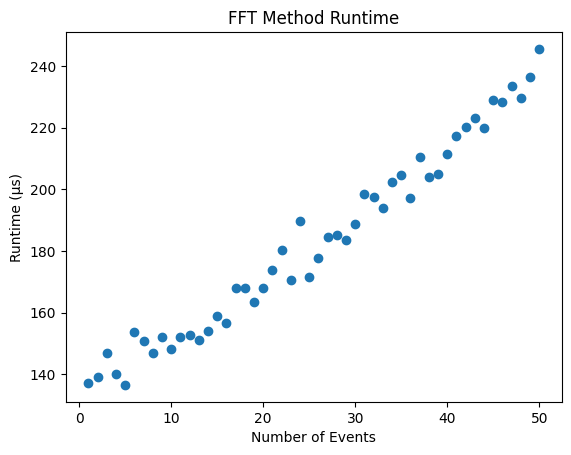

In [66]:
fft_times = [x/1000 for x in fft_times]
dp_times = [x/1000 for x in dp_times]
sim_times = [x/1000 for x in sim_times]
plt.clf()
plt.scatter(range(1, N+1), fft_times)
plt.title('FFT Method Runtime')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.show()

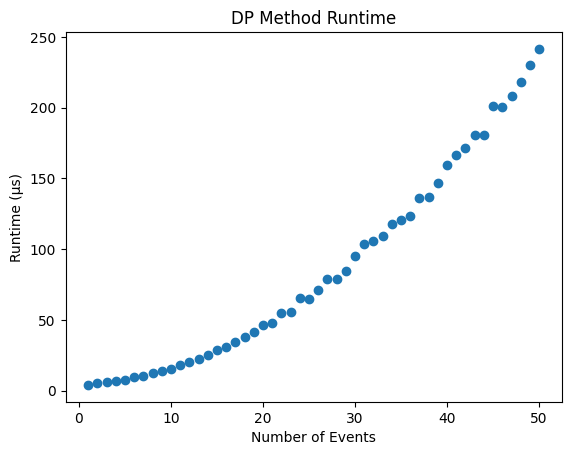

In [67]:
plt.clf()
plt.scatter(range(1, N+1), dp_times)
plt.title('DP Method Runtime')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.show()

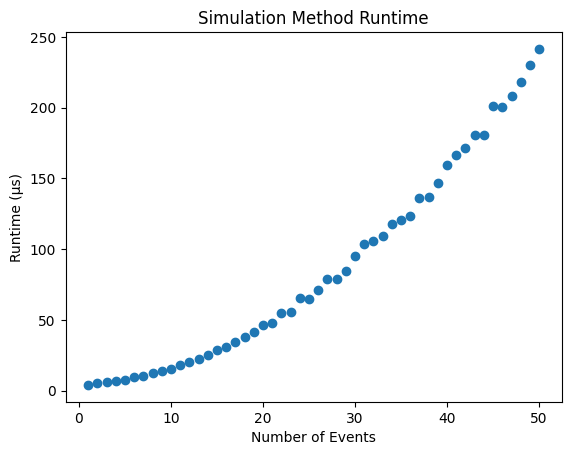

In [68]:
plt.clf()
plt.scatter(range(1, N+1), dp_times)
plt.title('Simulation Method Runtime')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.show()

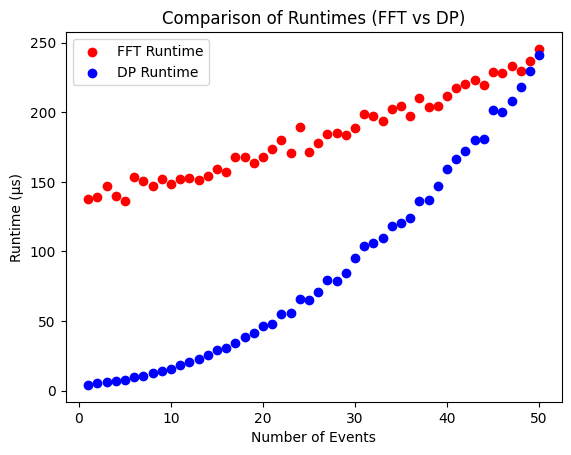

In [69]:
plt.clf()
sample_sizes = range(1, N+1)
plt.scatter(sample_sizes, fft_times, c='red', label='FFT Runtime')
plt.scatter(sample_sizes, dp_times, c='blue', label='DP Runtime')
plt.title('Comparison of Runtimes (FFT vs DP)')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.legend()
plt.show()

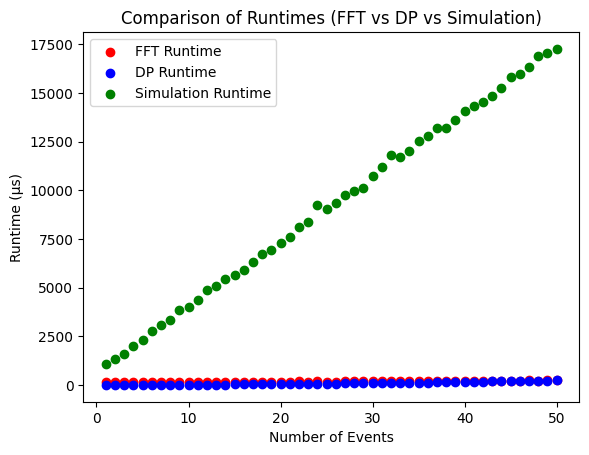

In [70]:
plt.clf()
sample_sizes = range(1, N+1)
plt.scatter(sample_sizes, fft_times, c='red', label='FFT Runtime')
plt.scatter(sample_sizes, dp_times, c='blue', label='DP Runtime')
plt.scatter(sample_sizes, sim_times, c='green', label='Simulation Runtime')
plt.title('Comparison of Runtimes (FFT vs DP vs Simulation)')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.legend()
plt.show()

In [71]:
runtime_df = pd.DataFrame({'shot_amnt': sample_sizes, 'dp_runtime_mean_microseconds': dp_times, 'fft_runtime_mean_microseconds': fft_times})

In [72]:
runtime_df.head()

,shot_amnt,dp_runtime_mean_microseconds,fft_runtime_mean_microseconds
0,1,4.05696,137.32448
1,2,5.32240,139.10148
2,3,5.89326,146.83542
3,4,6.63606,140.13608
4,5,7.53934,136.54988


In [73]:
runtime_df.to_csv('runtime_comparison.csv', index=False)

In [74]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Example data: Replace these with your actual data points
n_values = np.linspace(1, N, N) # Input sizes
T_n_values_logn = np.array(fft_times)  # Corresponding runtimes for O(nlog(n)) algorithm
T_n_values_n2 = np.array(dp_times)    # Corresponding runtimes for O(n^2) algorithm

# Transform features for a*nlog(n) + b
X_nlogn = np.vstack([n_values * np.log(n_values), np.ones(len(n_values))]).T

# Transform features for c*n^2 + d
X_n2 = np.vstack([n_values ** 2, np.ones(len(n_values))]).T

# Multiple linear regression for a*nlog(n) + b
reg_nlogn = LinearRegression().fit(X_nlogn, T_n_values_logn)
a, b = reg_nlogn.coef_[0], reg_nlogn.intercept_

# Multiple linear regression for c*n^2 + d
reg_n2 = LinearRegression().fit(X_n2, T_n_values_n2)
c, d = reg_n2.coef_[0], reg_n2.intercept_

print(f"Constants for a*nlog(n) + b: a = {a}, b = {b}")
print(f"Constants for c*n^2 + d: c = {c}, d = {d}")

Constants for a*nlog(n) + b: a = 0.5076217438182162, b = 138.88350534847976
Constants for c*n^2 + d: c = 0.09300357198877238, d = 7.254490647638917


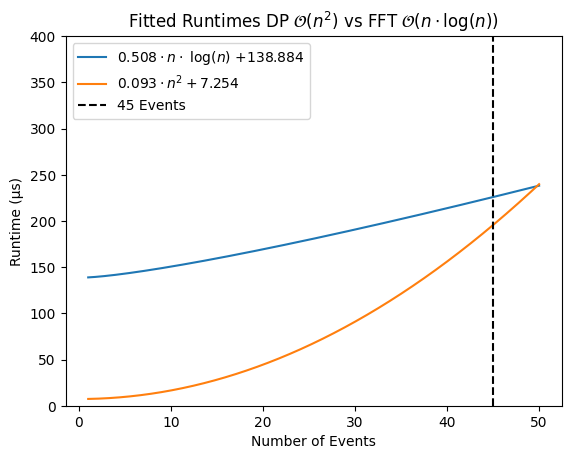

In [75]:
x = np.linspace(1, N, 10000)
nlogn_runtime = a * x * np.log(x) + b
n_squared_runtime = c * np.power(x, 2) + d

plt.plot(x, nlogn_runtime, label='${:.3f} \cdot n \cdot$ log($n$) $+ {:.3f}$'.format(a, b))
plt.plot(x, n_squared_runtime, label='${:.3f} \cdot n^2 + {:.3f}$'.format(c, d))
plt.title('Fitted Runtimes DP $\mathcal{O}$($n^2$) vs FFT $\mathcal{O}$($n \cdot $log($n$))')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.ylim(0, 400)
plt.axvline(x=45, color='black', linestyle='--', label='45 Events')
plt.legend()
plt.show()